In [6]:
import numpy as np
from astropy.constants import R_sun, M_sun, G, k_B, m_p
import astropy.units as u

from funcs.model import calculate_specific_flare_flux, calculate_angular_radius

def get_frac_area(radius):
    return np.sin(radius / 180 * np.pi / 2.)**2


import matplotlib.pyplot as plt
%matplotlib inline


import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 15}

# 10kK assumption

In [2]:
k_B

<<class 'astropy.constants.codata2018.CODATA2018'> name='Boltzmann constant' value=1.380649e-23 uncertainty=0.0 unit='J / K' reference='CODATA 2018'>

In [3]:
calculate_specific_flare_flux("TESS", flaret=7e3)

<Quantity 3.57701096e+10 erg / (cm2 s)>

In [4]:
a = 1.
qlum = 1e29 * u.erg / u.s
R = .5 * R_sun
Teff = np.linspace(5e3,5e4,20)
Fth = [calculate_specific_flare_flux("TESS", flaret=t) for t in Teff]
radius = [calculate_angular_radius(fth, a, qlum, R) for fth in Fth]
fill_factor = get_frac_area(np.array(radius)) * 4.

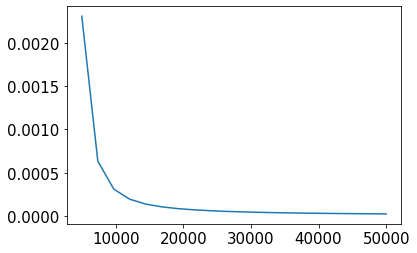

In [5]:
plt.plot(Teff, fill_factor)
#plt.yscale("log")

In [6]:
fill_factor

array([2.31087928e-03, 6.33670568e-04, 3.08814278e-04, 1.92164945e-04,
       1.35977478e-04, 1.03931929e-04, 8.35604071e-05, 6.96014625e-05,
       5.94993948e-05, 5.18794461e-05, 4.59426404e-05, 4.11956193e-05,
       3.73185269e-05, 3.40955297e-05, 3.13760390e-05, 2.90519726e-05,
       2.70438507e-05, 2.52919845e-05, 2.37507160e-05, 2.23845484e-05])

In [27]:
(1e-7 / u.s * np.pi * 2).to("1/d")

<Quantity 0.05428672 1 / d>

In [28]:
2piR/P = vsini / sin i

sin i = vsini * P / 2piR

SyntaxError: invalid syntax (<ipython-input-28-b2ec6745cc59>, line 1)

# back of the envelope calculation: pressure scale height

In [25]:
M = 0.16
Teff = 3030. * u.K
R =  0.199
g = G * (M * M_sun) / (R * R_sun)**2

In [26]:
H = k_B * Teff / (m_p * g)

In [27]:
H.decompose()

<Quantity 22575.98298498 m>

In [19]:
H.decompose()

<Quantity 13837.89950645 m>

In [20]:
13.8 / 180. #M6

0.07666666666666667

In [24]:
9.5 / 180. #L1

0.05277777777777778

In [28]:
22.6 / 180. #M5

0.12555555555555556

The pressure scale heights of the stars in our sample are about $5-13 \%$ of the solar

In [32]:
print(22.6 / (.199 * R_sun), 9.5 / (.107 * R_sun), 180. / (1. * R_sun) )

1.6324254591918916e-07 1 / m 1.2761973081640357e-07 1 / m 2.58732212160414e-07 1 / m


In [36]:
1.63 / 2.59, 1.28/2.59

(0.6293436293436293, 0.4942084942084942)

The relative height of atmospheres on M5-L1 dwarfs is $50-63\%$ percent of the relative solar height.

# latitude vs. flux

In [1]:
from altaipony.altai import equivalent_duration
from altaipony.flarelc import FlareLightCurve
import os
CWD = "/".join(os.getcwd().split("/")[:-2])
import pandas as pd


# Plot stuff
from funcs.model import full_model, aflare

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
NumExpr defaulting to 8 threads.


In [190]:
# Datasets we analysed
datasets = [#(100004076, "", "03_10_2020_11_27"),
            (237880881, "a", "03_10_2020_11_29"),
            (237880881, "b", "03_10_2020_11_29"),
            (277539431, "", "03_10_2020_11_30"),
             (44984200, "a", "04_08_2020_13_40"),
             (44984200, "b", "04_08_2020_13_40"),
             (44984200, "", "02_08_2020_17_44"),
            ]

In [191]:
res= pd.read_csv(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv").loc[:6]
res.suffix = res.suffix.fillna("").astype(str)
vals = list(res.columns.values)
vals.remove("suffix")
vals.remove("tstamp")
vals.remove("color")
vals.remove("linestyle")
vals.remove("ID")
res[vals] = res[vals].astype(float) 

In [192]:
est = {}
plt.figure(figsize=(10,10))
for j, row in res.iterrows():
  
    # Get data
    #df = pd.read_csv(f"{CWD}/analysis/results/mcmc/{row.tstamp}_{row.ID}{row.suffix}_converted_mcmc_sample.csv")
    lc = pd.read_csv(f"{CWD}/data/lcs/{row.tstamp}_{row.ID}.csv")
    props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
    target = props[props.ID == int(row.ID)].iloc[0]
 
    # Pick up the input parameters
    inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
    inits = inits[(inits.ID == str(row.ID)+row.suffix) & (inits.tstamp==row.tstamp)].iloc[0]

    qlum = inits.qlum_erg_s * u.erg / u.s
    Fth = inits.Fth * u.erg/ u.cm**2 / u.s
    median = inits['median']
    R = inits.R_Rsun * R_sun
    
     # Plot the results
    N = 50
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    #inds = np.random.randint(df.shape[0], size=N)


    a = row.a_50
    phi_a = (row.t0_d_50 -lc.t[0]) / target.Prot_d * 2 * np.pi 
    #theta_a = row.latitude_deg_50 / 180 * np.pi
    fwhm = row.fwhm_d_50 / target.Prot_d * 2 * np.pi
    print("FWHM", fwhm, row.fwhm_d_50, fwhm/a)
    #i = row.i_deg_50 / 180 * np.pi
    i = np.pi/2

    phi0 = phi_a%(2.*np.pi) - (row.phase_deg_50  / 180 * np.pi)
    flare = aflare(phi, phi_a, fwhm, a*median)+ median
    print(f"ID: {row.ID}\n")
    est[str(row.ID) + row.suffix] = {}
    for theta_a in np.arange(0.1,89.9,2): 
        th = theta_a / 180. * np.pi
        fullmodel = full_model(phi_a, th, a, fwhm, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)

        flc = FlareLightCurve(time=time, detrended_flux=fullmodel, )
        flc.it_med = np.full_like(time, median)
        ED = equivalent_duration(flc,0,-2)
        
        est[str(row.ID) + row.suffix][theta_a] = ED * qlum.value
            
#         if (str(row.ID) == "237880881") & (str(row.suffix) == "a"):
#             if theta_a > 50:
#                 c = "g"
#             else:
#                 c = "grey"
#             plt.plot(flc.time, flc.detrended_flux, c=c, alpha=.3)
            

FWHM 4.864182299516234 0.14709014484294103 1.9740832016054088
ID: 277539431

FWHM 0.4041047070173801 0.022590735654042005 0.14554583348155165
ID: 237880881

FWHM 2.08420318880067 0.116513573016813 4.0580457594477375
ID: 237880881

FWHM 5.363672961444123 0.09646302233846601 17.167764328193098
ID: 44984200

FWHM 4.058174597069022 0.072984275817045 12.382881176205354
ID: 44984200

FWHM 4.555291164775444 0.081924672988944 64.29232561461102
ID: 44984200

FWHM 5.544458053165317 0.326630689378852 48.4362670543771
ID: 100004076



<Figure size 720x720 with 0 Axes>

In [214]:
print(Fth)

90616356361.5605 erg / (cm2 s)


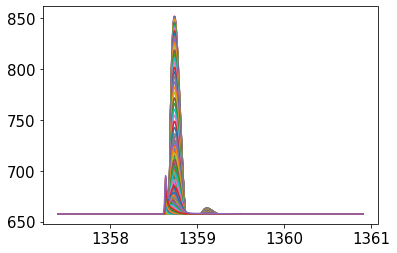

In [159]:
sim = {}
# time = 
# phi = 
# qlum = 
# Fth =
# R =
# median =
# i = 
for theta_a in np.arange(.1,89.9,2): 
    sim[theta_a] = {}
    th = theta_a / 180. * np.pi
    for wiggle in [0.05, .1,.2,.25,.4,.5, 1.,2.,60., 120.]:#np.arange(.2,6.5,.5):
        awiggle = wiggle #/ 180. * np.pi
        fullmodel = full_model(21., th, 3., awiggle, i, phi0=phi0,
                           phi=phi, num_pts=50, qlum=qlum,
                           Fth=Fth, R=R, median=median)

        flc = FlareLightCurve(time=time, detrended_flux=fullmodel, )
        flc.it_med = np.full_like(time, median)
        ED = equivalent_duration(flc,0,-2)
        sim[theta_a][wiggle] = ED * qlum.value
        if wiggle < 2.:
            plt.plot(time, fullmodel)

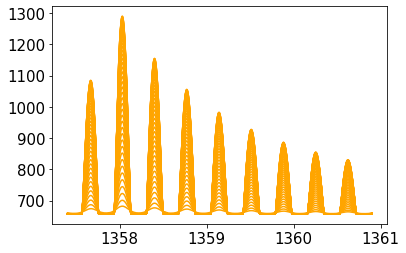

In [174]:
sim = {}
# time = 
# phi = 
# qlum = 
# Fth =
# R =
# median =
# i = 
for theta_a in np.arange(.1,89.9,2): 
    sim[theta_a] = {}
    th = theta_a / 180. * np.pi
    for wiggle, phia in [(0.15, 20.), (60.,10.)]:#np.arange(.2,6.5,.5):
        awiggle = wiggle #/ 180. * np.pi
        fullmodel = full_model(phia, th, 1., awiggle, i, phi0=phi0,
                           phi=phi, num_pts=50, qlum=qlum,
                           Fth=Fth, R=R, median=median)

        flc = FlareLightCurve(time=time, detrended_flux=fullmodel, )
        flc.it_med = np.full_like(time, median)
        ED = equivalent_duration(flc,0,-2)
        sim[theta_a][wiggle] = ED * qlum.value
        if phia==10.:

            plt.plot(time, fullmodel, c=c)

In [175]:
simdf = pd.DataFrame(sim).T

simdf2 = simdf/simdf.loc[.1]
simdf2

,0.15,60.00
0.1,1.000000,1.000000
2.1,0.999363,0.999349
4.1,0.997538,0.997483
6.1,0.994527,0.994405
8.1,0.990333,0.990118
10.1,0.984962,0.984627
12.1,0.978420,0.977940
14.1,0.970715,0.970064
16.1,0.961857,0.961010
18.1,0.951862,0.950788


In [193]:
# reform = {(outerKey, innerKey): values for outerKey, 
#           innerDict in est.items() for innerKey, 
#           values in innerDict.items()}
esti = pd.DataFrame(est)
esti

,277539431,237880881a,237880881b,44984200,44984200a,44984200b,100004076
0.1,9.499322e+33,8.950723e+32,6.733427e+33,6.646659e+32,4.055394e+32,1.009413e+32,8.967684e+31
2.1,9.484258e+33,8.953677e+32,6.714151e+33,6.642361e+32,4.052772e+32,1.008747e+32,8.961729e+31
4.1,9.467625e+33,8.992873e+32,6.706977e+33,6.629999e+32,4.045225e+32,1.006854e+32,8.944858e+31
6.1,9.441869e+33,8.903064e+32,6.689868e+33,6.609588e+32,4.032762e+32,1.003735e+32,8.917090e+31
8.1,9.386290e+33,8.928377e+32,6.652823e+33,6.581152e+32,4.015400e+32,9.993944e+31,8.878461e+31
10.1,9.354573e+33,8.837632e+32,6.621070e+33,6.544727e+32,3.993160e+32,9.938374e+31,8.829016e+31
12.1,9.295502e+33,8.805783e+32,6.570289e+33,6.500356e+32,3.966071e+32,9.870707e+31,8.768817e+31
14.1,9.220279e+33,8.783890e+32,6.529896e+33,6.448094e+32,3.934163e+32,9.791025e+31,8.697936e+31
16.1,9.126284e+33,8.672812e+32,6.470228e+33,6.388005e+32,3.897478e+32,9.699427e+31,8.616461e+31
18.1,9.032346e+33,8.595922e+32,6.396192e+33,6.320166e+32,3.856061e+32,9.596024e+31,8.524490e+31


In [9]:
edf = esti.loc[[10,45,80]].T
edf["frac45"] = edf[45]/edf[10]
edf["frac80"] = edf[80]/edf[10]
np.array([edf.frac45.median(), edf.frac45.std(), edf.frac80.median(), edf.frac80.std()])*100.
edf

,10,45,80,frac45,frac80
277539431,9.353213e+33,6.808756e+33,2.498608e+33,0.727959,0.267139
237880881a,8.840060e+32,6.971382e+32,2.189505e+33,0.788612,2.476799
237880881b,6.621564e+33,4.775717e+33,1.482600e+33,0.721237,0.223905
44984200,6.546737e+32,4.710485e+32,1.215480e+32,0.719516,0.185662
44984200a,3.994388e+32,2.873375e+32,7.408579e+31,0.719353,0.185475
44984200b,9.941440e+31,7.142695e+31,1.773566e+31,0.718477,0.178401
100004076,8.831744e+31,6.342784e+31,1.564060e+31,0.718180,0.177095


In [142]:
esti2 = esti/esti.loc[.1]
esti2

,277539431,237880881a,237880881b,44984200,44984200a,44984200b,100004076
0.1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2.1,0.998414,1.000330,0.997137,0.999353,0.999353,0.999341,0.999336
4.1,0.996663,1.004709,0.996072,0.997494,0.997492,0.997465,0.997455
6.1,0.993952,0.994675,0.993531,0.994423,0.994419,0.994375,0.994358
8.1,0.988101,0.997503,0.988029,0.990144,0.990138,0.990075,0.990051
10.1,0.984762,0.987365,0.983314,0.984664,0.984654,0.984570,0.984537
12.1,0.978544,0.983807,0.975772,0.977989,0.977974,0.977866,0.977824
14.1,0.970625,0.981361,0.969773,0.970126,0.970106,0.969972,0.969920
16.1,0.960730,0.968951,0.960912,0.961085,0.961060,0.960898,0.960835
18.1,0.950841,0.960361,0.949916,0.950879,0.950847,0.950654,0.950579


277539431 0.24796793825924382 [82.10524775]
0.24796793825924382
237880881a
237880881a 0.6610085404023537 [58.47434817]
0.6610085404023537
237880881b 0.5345957928195516 [58.47434817]
0.5345957928195516
44984200 0.3125327979453976 [72.11787773]
0.3125327979453976
44984200a
44984200a 0.09682712828185971 [85.67120874]
0.09682712828185971
44984200b 0.07313856052244493 [85.67120874]
0.07313856052244493
100004076 0.6935949305002013 [46.04778651]
0.6935949305002013


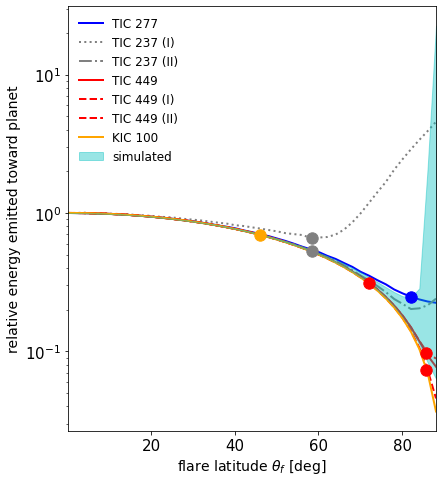

In [177]:
plt.figure(figsize=(6,6.5))
res.ID = res.ID.astype(str)

for col in esti2:

    if "a" in col:
        print(col)
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "a")]
        suff = " (I)"
    elif "b" in col:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "b")]
        suff = " (II)"
      
    else:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "")]
        suff = ""
    c = _.iloc[0].color
    l = _.iloc[0].linestyle
    lab = str(props[props.ID == int(_.ID)].iloc[0].prefix) + " " +  _.iloc[0].ID[:3] + suff
    plt.plot(esti2.index, esti2[col], color =c, label=lab, linestyle=l, linewidth=2, zorder=-4)
    I = np.argmin(np.abs(esti2.index.values - _.iloc[0].latitude_deg_50))
    en = esti2.loc[esti2.index[I], str(col)]
    print(col, en, _.latitude_deg_50.values)
    print( esti2.loc[esti2.index[I], str(col)])
    plt.scatter(x=_.latitude_deg_50, y=en, c=c, s=130, alpha=1.)#label=lab)

    

plt.fill_between(simdf2.index, simdf2[.15],simdf2[60.], color="c", alpha=.4, label="simulated", zorder=-1)    
plt.legend(frameon=False, fontsize=12)
plt.xlim(0.1,88.)
#plt.ylim(0.,2.5)
plt.yscale("log")
plt.tight_layout()
# plt.ylabel(r"$ED$ [s]", fontsize=14)
#plt.ylabel(r"$E_\mathrm{flare}$ [erg]", fontsize=14)
plt.ylabel(r"relative energy emitted toward planet", fontsize=14)

plt.xlabel(r"flare latitude $\theta_f$ [deg]", fontsize=14);

277539431 0.14905963891523358 [82.10524775]
0.24796793825924382
237880881b 0.531122188571459 [58.47434817]
0.5345957928195516
44984200 0.3125327979453976 [72.11787773]
0.3125327979453976
44984200b 0.09319658604181755 [85.67120874]
0.07313856052244493


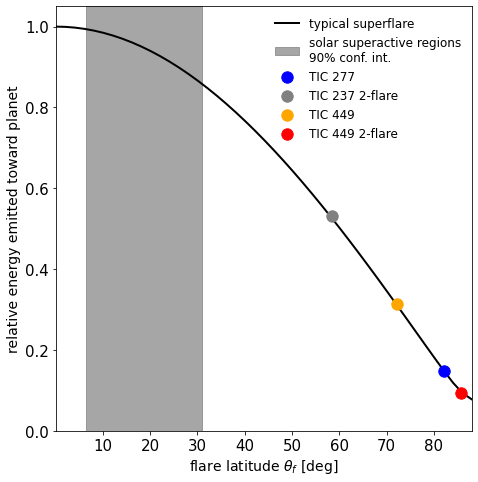

In [212]:
plt.figure(figsize=(6.5,6.5))
res.ID = res.ID.astype(str)
#esti2 = esti2.drop("100004076", axis=1)
for col in esti2:
    if "a" in col:
        continue
    elif "b" in col:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "b")]
        suff = " 2-flare"
        
      
    else:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "")]
        suff = ""
    
    c = _.iloc[0].color
    l = _.iloc[0].linestyle
    lab = str(props[props.ID == int(_.ID)].iloc[0].prefix) + " " +  _.iloc[0].ID[:3] + suff
    
    I = np.argmin(np.abs(esti2.index.values - _.iloc[0].latitude_deg_50))
    en = esti2.loc[esti2.index[I], str("44984200")]
    print(col, en, _.latitude_deg_50.values)
    print( esti2.loc[esti2.index[I], str(col)])
    if col == "44984200":
        c = "orange"
    plt.scatter(x=_.latitude_deg_50, y=en, c=c, s=130, alpha=1.,label=lab)

    
plt.plot(esti2.index, esti2["44984200"], color ="k", label="typical superflare", linestyle="solid", linewidth=2, zorder=-4)

plt.axvspan(6.4, 31., color="grey", zorder=-20, alpha=0.7, label="solar superactive regions\n90% conf. int. ")
plt.legend(frameon=False, fontsize=12, loc=1)
plt.xlim(0.1,88.)
plt.ylim(0.,1.05)
#plt.yscale("log")
plt.tight_layout()
# plt.ylabel(r"$ED$ [s]", fontsize=14)
#plt.ylabel(r"$E_\mathrm{flare}$ [erg]", fontsize=14)
plt.ylabel(r"relative energy emitted toward planet", fontsize=14)

plt.xlabel(r"flare latitude $\theta_f$ [deg]", fontsize=14);

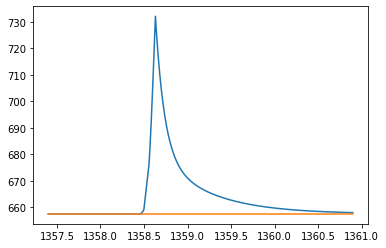

In [84]:
plt.plot(flc.time, flc.detrended_flux)
plt.plot(flc.time, flc.it_med)

In [85]:
equivalent_duration(flc,0,-4)

2868.7908427679163

In [54]:
len(time)

891

In [109]:
row.ID

'100004076'

# Inclinations from Elisabeth

In [11]:
incl = pd.read_csv(f"{CWD}/data/inclinations/inclination_output.dat", delimiter=r"\s+")
incl

,prefix,id,inclination,inclination_lowerr,inclination_uperr
0,KIC100004076,58.702743,-14.325956,17.799433,NaN
1,TIC237880881,22.278168,-3.993050,3.945734,NaN
2,TIC44984200,33.130091,-0.831807,0.882270,NaN
3,TIC277539431,83.029951,-6.038076,4.910168,NaN
4,TIC452922110,49.327840,-3.186934,3.520259,NaN


In [31]:
2.1e34/5e32

42.00000000000001